## NSGA-Ⅱ

In [1]:
# ライブラリーのインポート
import array
import random
import json

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools

In [2]:
# 適合度を最小化することで最適化されるような適合度クラスの作成
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
# 個体クラスIndividualを作成
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)
# Toolboxの作成
toolbox = base.Toolbox()
# 遺伝子が取り得る値の範囲を指定
BOUND_LOW, BOUND_UP = 0.0, 1.0
# 1つの個体内の遺伝子の数を指定
NDIM = 30

In [3]:
# 遺伝子生成の関数
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [4]:
# 遺伝子を生成する関数"attr_gene"を登録
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
# 個体を生成する関数”individual"を登録
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
# 個体集団を生成する関数"population"を登録
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# 評価関数"evaluate"を登録
toolbox.register("evaluate", benchmarks.zdt1)
# 交叉を行う関数"mate"を登録
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
# 変異を行う関数"mutate"を登録
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
# 個体選択法"select"を登録
toolbox.register("select", tools.selNSGA2)

In [5]:
def main():
    random.seed(1)

    NGEN = 250 # 繰り返し世代数
    MU = 100 # 集団内の個体数
    CXPB = 0.9 # 交叉率
    
    # 世代ループ中のログに何を出力するかの設定
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"
    
    # 第一世代の生成
    pop = toolbox.population(n=MU)
    pop_init = pop[:]
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    pop = toolbox.select(pop, len(pop))
    
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    # 最適計算の実行
    for gen in range(1, NGEN):
        # 子母集団生成
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]
        
        # 交叉と突然変異
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            # 交叉させる個体を選択
            if random.random() <= CXPB:
                # 交叉
                toolbox.mate(ind1, ind2)
            
            # 突然変異
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            
            # 交叉と突然変異させた個体は適応度を削除する
            del ind1.fitness.values, ind2.fitness.values
        
        # 適応度を削除した個体について適応度の再評価を行う
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # 次世代を選択
        pop = toolbox.select(pop + offspring, MU)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream)

    # 最終世代のハイパーボリュームを出力
    print("Final population hypervolume is %f" % hypervolume(pop, [11.0, 11.0]))

    return pop, pop_init, logbook

In [6]:
if __name__ == '__main__':

    pop, pop_init, stats = main()

gen	evals	std	min                            	avg	max                    
0  	100  	   	[1.46323228e-03 2.36182135e+00]	   	[0.99439341 5.91891494]
1  	100  	   	[1.46323228e-03 2.36182135e+00]	   	[0.99439341 6.20469599]
2  	100  	   	[1.46323228e-03 2.21681110e+00]	   	[0.99439341 5.51487706]
3  	100  	   	[1.74879809e-05 1.85288017e+00]	   	[0.99439341 5.07668097]
4  	100  	   	[1.74879809e-05 1.85288017e+00]	   	[0.99881335 5.00956299]
5  	100  	   	[1.74879809e-05 1.67315878e+00]	   	[0.98033297 4.83000075]
6  	100  	   	[1.18746272e-05 1.42628755e+00]	   	[0.98047191 4.75650909]
7  	100  	   	[1.08501188e-05 1.39662396e+00]	   	[0.98047191 5.11481387]
8  	100  	   	[1.08501188e-05 1.38141982e+00]	   	[0.98299866 4.76645552]
9  	100  	   	[1.08501188e-05 1.33253514e+00]	   	[0.98047191 4.26861668]
10 	100  	   	[1.08501188e-05 1.08560177e+00]	   	[0.98047191 4.09068347]
11 	100  	   	[1.08501188e-05 1.08560177e+00]	   	[0.98047191 3.56168111]
12 	100  	   	[1.08501188e-05 9.060466

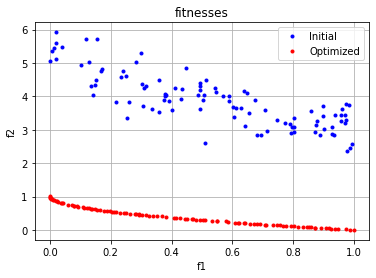

In [7]:
fitnesses_init = np.array([list(pop_init[i].fitness.values) for i in range(len(pop_init))])
fitnesses = np.array([list(pop[i].fitness.values) for i in range(len(pop))])
plt.plot(fitnesses_init[:,0], fitnesses_init[:,1], "b.", label="Initial")
plt.plot(fitnesses[:,0], fitnesses[:,1], "r.", label="Optimized" )
plt.legend(loc="upper right")
plt.title("fitnesses")
plt.xlabel("f1")
plt.ylabel("f2")
plt.grid(True)